In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy 
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from sunkit_image import coalignment
from sun_blinker import SunBlinker, ImageBlinker

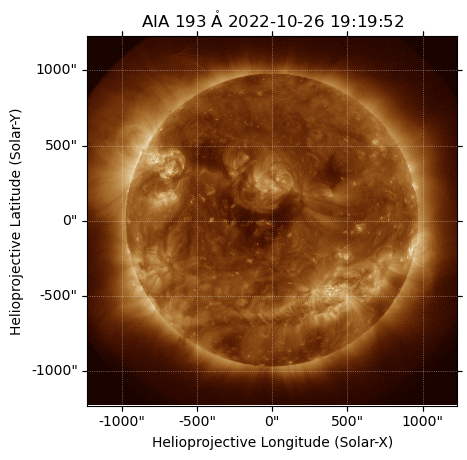

In [2]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221026/193/lvl15/aia.lev1_euv_12s.2022-10-26T191951Z.193.image.fits")
aia_193_map.plot()

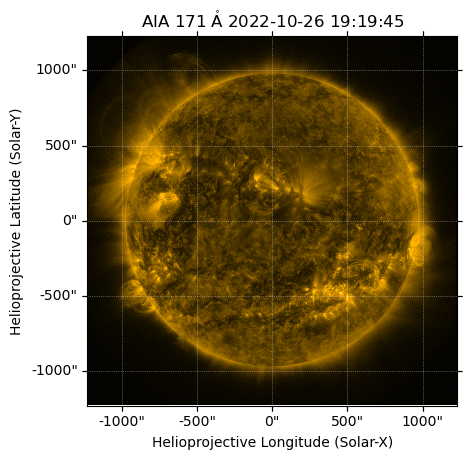

In [3]:
aia_171_map = sunpy.map.Map("../../src/AIA/20221026/171/lvl15/aia.lev1_euv_12s.2022-10-26T191951Z.171.image.fits")
aia_171_map.plot()

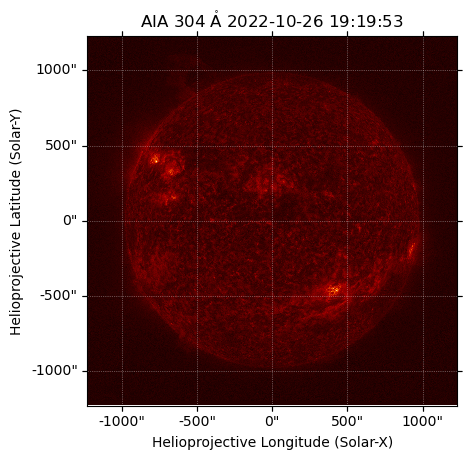

In [4]:
aia_304_map = sunpy.map.Map("../../src/AIA/20221026/304/aia.lev1_euv_12s.2022-10-26T191951Z.304.image.fits")
aia_304_map.plot()

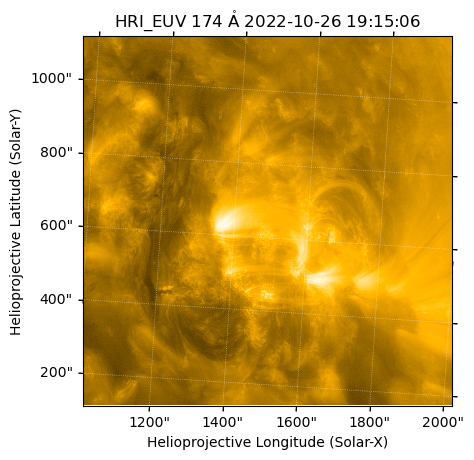

In [6]:
hri_174_map = sunpy.map.Map("../../src/EUI/HRI/euv174/20221026/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits")
hri_174_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
hri_174_map.plot()

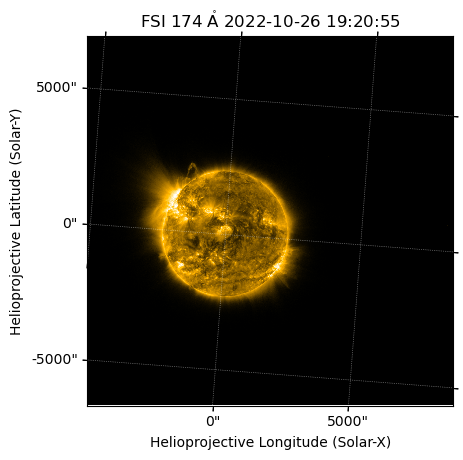

In [7]:
fsi_174_map = sunpy.map.Map("../../src/EUI/FSI/euv174/20221026/solo_L2_eui-fsi174-image_20221026T192050235_V01.fits")
fsi_174_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
fsi_174_map.plot()

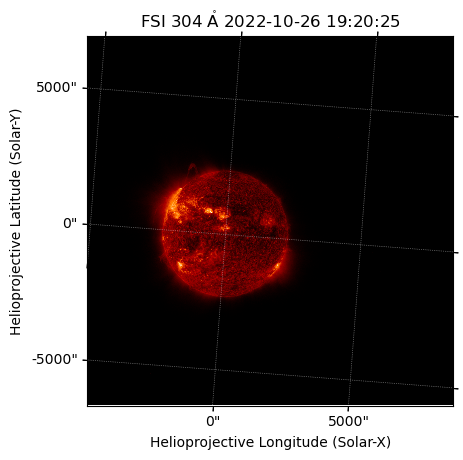

In [8]:
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221026/solo_L2_eui-fsi304-image_20221026T192020235_V01.fits")
fsi_304_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
fsi_304_map.plot()

In [9]:
def derotate_fsi(fsi_map, hri_map,algorithm="adaptive"):
    out_frame = hri_map.coordinate_frame
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(fsi_map.data.shape,
                                        out_center,
                                        scale=u.Quantity(fsi_map.scale),
                                        rotation_matrix=hri_map.rotation_matrix) 
    # correct the tiny rotation matrix difference between FSI and HRI, which simply the coalignment
    out_wcs = WCS(header)

    with propagate_with_solar_surface():
        fsi_map_derot = fsi_map.reproject_to(out_wcs,algorithm=algorithm)

    return fsi_map_derot


In [10]:
fsi_174_map_hri_time = derotate_fsi(fsi_174_map,hri_174_map)

In [18]:
fsi_174_crop = fsi_174_map_hri_time.submap(SkyCoord(900*u.arcsec,100*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1900*u.arcsec,1100*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame))

In [19]:
hri_174_map_repro = hri_174_map.reproject_to(fsi_174_crop.wcs)

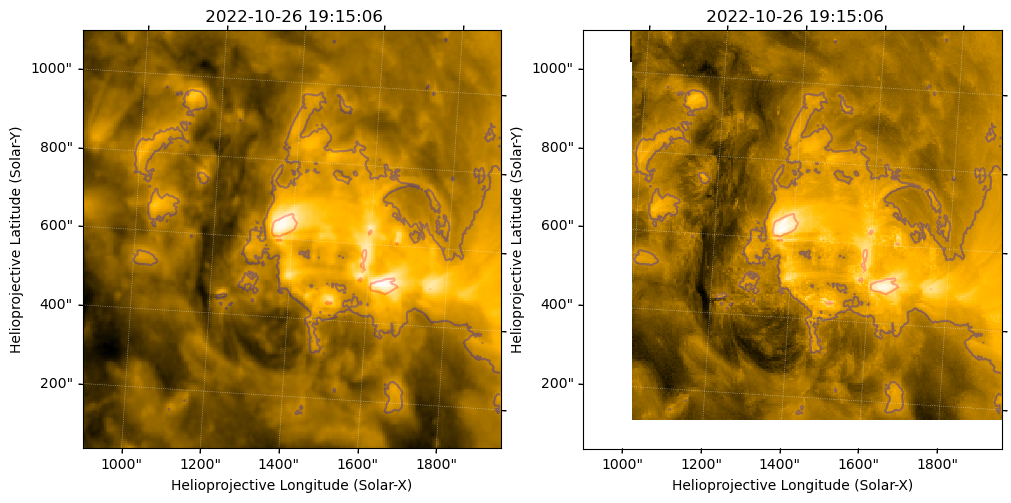

In [20]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=fsi_174_crop)
im1 = fsi_174_crop.plot()

ax2 = fig.add_subplot(122,projection=hri_174_map_repro)
im2 = hri_174_map_repro.plot()

hri_levels = [1000,5000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    hri_174_map_repro.draw_contours(hri_levels,colors=["b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)


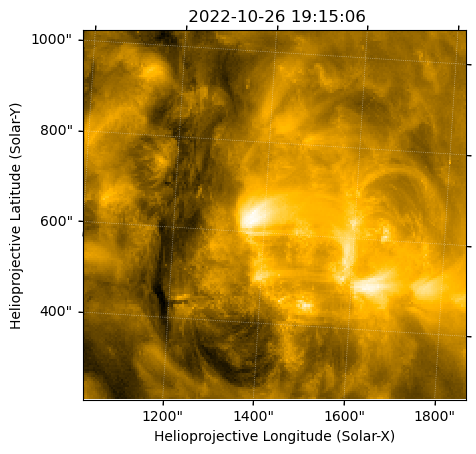

In [24]:
hri_174_map_repro_cut = hri_174_map_repro.submap([30,37]*u.pix,
                                                 top_right=[220,220]*u.pix)
hri_174_map_repro_cut.plot()

In [25]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [26]:
Txshift_hri, Tyshift_hri = coalign_shift(fsi_174_crop,hri_174_map_repro_cut)
print(Txshift_hri, Tyshift_hri)

-0.0235313 arcsec 7.82867 arcsec


In [27]:
hri_174_map_shifted = hri_174_map.shift_reference_coord(Txshift_hri,Tyshift_hri)

In [28]:
SunBlinker(hri_174_map_shifted, fsi_174_crop, reproject=True, fps=1)

In [29]:
fsi_304_map_hri_time = derotate_fsi(fsi_304_map,hri_174_map)

In [30]:
fsi_304_crop = fsi_304_map_hri_time.submap(SkyCoord(900*u.arcsec,100*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1900*u.arcsec,1100*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame))

In [31]:
aia_304_map_repro = aia_304_map.reproject_to(fsi_304_crop.wcs)

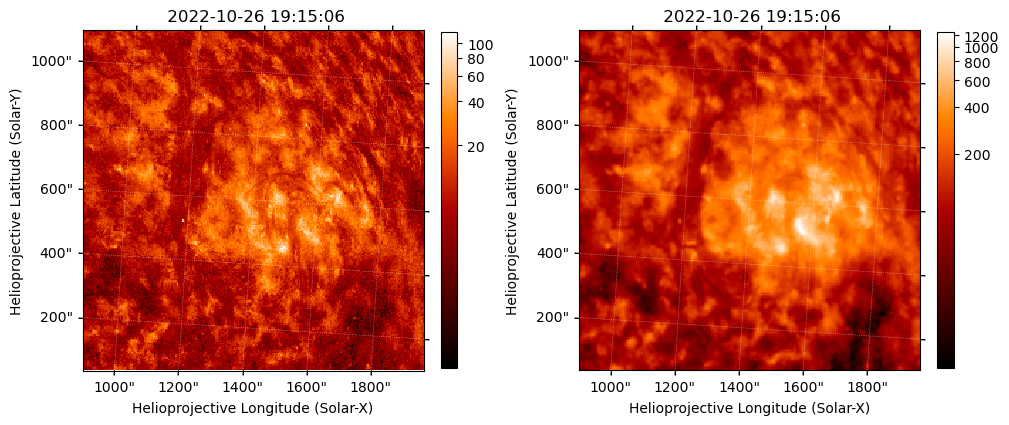

In [32]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_repro)
im1 = aia_304_map_repro.plot()
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=fsi_304_crop)
im2 = fsi_304_crop.plot()
plt.colorbar(ax=ax2,shrink=0.75)

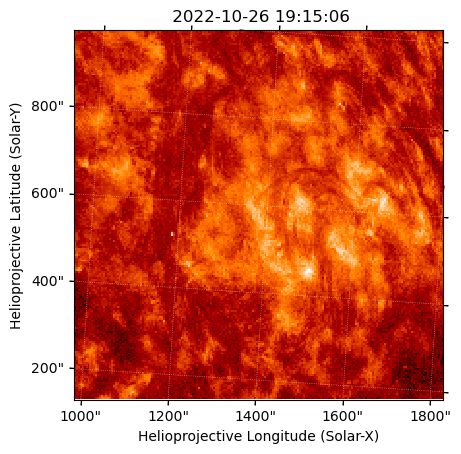

In [33]:
aia_304_map_repro_cut = aia_304_map_repro.submap([20,20]*u.pix,
                                                    top_right=[aia_304_map_repro.data.shape[1]-30,
                                                               aia_304_map_repro.data.shape[0]-30]*u.pix)
aia_304_map_repro_cut.plot()

In [34]:
Txshift_aia_fsi, Tyshift_aia_fsi = coalign_shift(fsi_304_crop,aia_304_map_repro_cut)
print(Txshift_aia_fsi, Tyshift_aia_fsi)

6.3736 arcsec 0.685765 arcsec


In [35]:
fsi_304_crop_shift = fsi_304_crop.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
hri_174_map_shifted_toaia = hri_174_map_shifted.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)

In [37]:
hri_174_map_shifted_toaia.save("../../src/coalign_map/20221026/hri_174_map_shifted_toaia.fits",overwrite=True)